# Logistic regression with PyMC3

## Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
from pathlib import Path
import pickle
import pandas as pd
import numpy as np
from scipy import stats

from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import theano
import pymc3 as pm
from pymc3.variational.callbacks import CheckParametersConvergence
import statsmodels.formula.api as smf

import matplotlib.pyplot as plt
from matplotlib import animation
import seaborn as sns
from IPython.display import HTML

In [32]:
data_path = Path('data')
fig_path = Path('figures')
model_path = Path('models')
for p in [data_path, fig_path, model_path]:
    if not p.exists():
        p.mkdir()

## The Data

### Download from UCI

In [4]:
data = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
                   header=None,
                   names=['age', 'workclass', 'fnlwgt', 'education-categorical', 'educ',
                          'marital-status', 'occupation', 'relationship', 'race', 'sex',
                          'captial-gain', 'capital-loss', 'hours', 'native-country', 'income'])
data = data.loc[~pd.isnull(data['income']) & (data['native-country'] == " United-States"),
                ['income', 'age', 'educ', 'hours', 'sex']]
data.income = (data.income.str.strip() == '>50K').astype(int)
data.to_csv('data/income_data.csv', index=False)

### Load from Disk

In [5]:
data = pd.read_csv('data/income_data.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29170 entries, 0 to 29169
Data columns (total 5 columns):
income    29170 non-null int64
age       29170 non-null int64
educ      29170 non-null int64
hours     29170 non-null int64
sex       29170 non-null object
dtypes: int64(4), object(1)
memory usage: 1.1+ MB


### Models

In [6]:
simple_model = 'income ~ hours + educ'
full_model = 'income ~ sex + age+ I(age ** 2) + hours + educ'

### Quick exploration

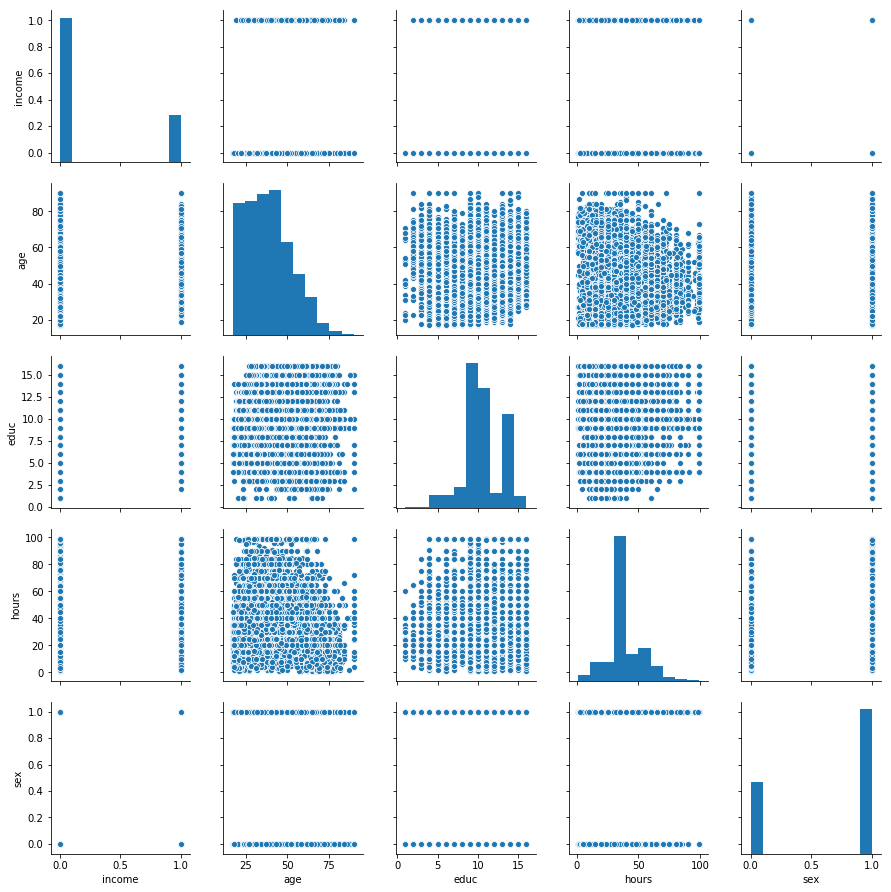

In [7]:
sns.pairplot(data.assign(
    sex=lambda x: x.sex.str.strip().map({'Male': 1, 'Female': 0})))

## MAP Inference

### Manual Model Specification

In [8]:
with pm.Model() as manual_logistic_model:
    # random variables for coefficients with
    # uninformative priors for each parameter

    intercept = pm.Normal('intercept', 0, sd=100)
    beta_1 = pm.Normal('beta_1', 0, sd=100)
    beta_2 = pm.Normal('beta_2', 0, sd=100)

    # Transform random variables into vector of probabilities p(y_i=1)
    # according to logistic regression model specification.
    likelihood = pm.invlogit(intercept + beta_1 *
                             data.hours + beta_2 * data.educ)

    # Bernoulli random vector with probability of success
    # given by sigmoid function and actual data as observed
    pm.Bernoulli(name='logit', p=likelihood, observed=data.income)

In [9]:
manual_logistic_model.model

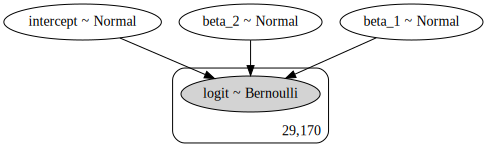

In [10]:
pm.model_to_graphviz(manual_logistic_model)

In [11]:
graph = pm.model_to_graphviz(manual_logistic_model)
graph.save('figures/log_reg.dot')

'figures/log_reg.dot'

### Run Inference

In [12]:
with manual_logistic_model:
    # compute maximum a-posteriori estimate
    # for logistic regression weights
    manual_map_estimate = pm.find_MAP()

logp = -13,983, ||grad|| = 9.0944: 100%|██████████| 33/33 [00:00<00:00, 235.73it/s]  


In [13]:
def print_map(result):
    return pd.Series({k: np.asscalar(v) for k, v in result.items()})

In [14]:
print_map(manual_map_estimate)

intercept   -6.561846
beta_1       0.040682
beta_2       0.350388
dtype: float64

### GLM Model

In [15]:
with pm.Model() as logistic_model:
    pm.glm.GLM.from_formula(simple_model,
                            data,
                            family=pm.glm.families.Binomial())

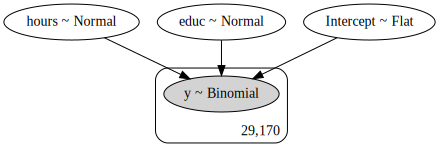

In [16]:
pm.model_to_graphviz(logistic_model)

In [17]:
with logistic_model:
    map_estimate = pm.find_MAP()

logp = -13,982, ||grad|| = 7.2784: 100%|██████████| 33/33 [00:00<00:00, 299.79it/s]      


In [18]:
model = smf.logit(formula=simple_model, data=data)
result = model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.478799
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                 income   No. Observations:                29170
Model:                          Logit   Df Residuals:                    29167
Method:                           MLE   Df Model:                            2
Date:                Thu, 27 Dec 2018   Pseudo R-squ.:                  0.1415
Time:                        23:44:43   Log-Likelihood:                -13967.
converged:                       True   LL-Null:                       -16268.
                                        LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -6.5619      0.094    -69.511      0.000      -6.747      -6.377
hours          0.0407      0.

In [19]:
print_map(map_estimate)

Intercept   -6.561862
hours        0.040681
educ         0.350390
dtype: float64

In [20]:
result.params

Intercept   -6.561860
hours        0.040681
educ         0.350390
dtype: float64

## Markov Chain Monte Carlo

In [21]:
def plot_traces(traces, burnin=2000):
    summary = pm.summary(traces[burnin:])['mean'].to_dict()
    ax = pm.traceplot(traces[burnin:],
                      figsize=(15, len(traces.varnames)*1.5),
                      lines=summary)

    for i, mn in enumerate(summary.values()):
        ax[i, 0].annotate(f'{mn:.2f}', xy=(mn, 0),
                          xycoords='data', xytext=(5, 10),
                          textcoords='offset points',
                          rotation=90, va='bottom',
                          fontsize='large',
                          color='#AA0022')

### Define the Model

In [22]:
with pm.Model() as logistic_model:
    pm.glm.GLM.from_formula(formula=full_model,
                            data=data,
                            family=pm.glm.families.Binomial())

In [23]:
logistic_model.basic_RVs

[Intercept, sex[T. Male], age, I(age ** 2), hours, educ, y]

### Metropolis-Hastings
We will use the Metropolis-Hastings algorithm to sample from the posterior distribution.

Explore the hyperparameters of Metropolis-Hastings such as the proposal distribution variance to speed up the convergence. 
Use `plot_traces` function to visually inspect the convergence.

You may also use MAP-estimate to initialize the sampling scheme to speed things up. This will make the warmup (burnin) period shorter since you will start from a probable point.

In [24]:
with logistic_model:
    trace_mh = pm.sample(tune=1000,
                         draws=5000,
                         step=pm.Metropolis(),
                         cores=4)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [educ]
>Metropolis: [hours]
>Metropolis: [I(age ** 2)]
>Metropolis: [age]
>Metropolis: [sex[T. Male]]
>Metropolis: [Intercept]
Sampling 4 chains: 100%|██████████| 24000/24000 [22:05<00:00, 18.10draws/s]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


### Inspect Trace

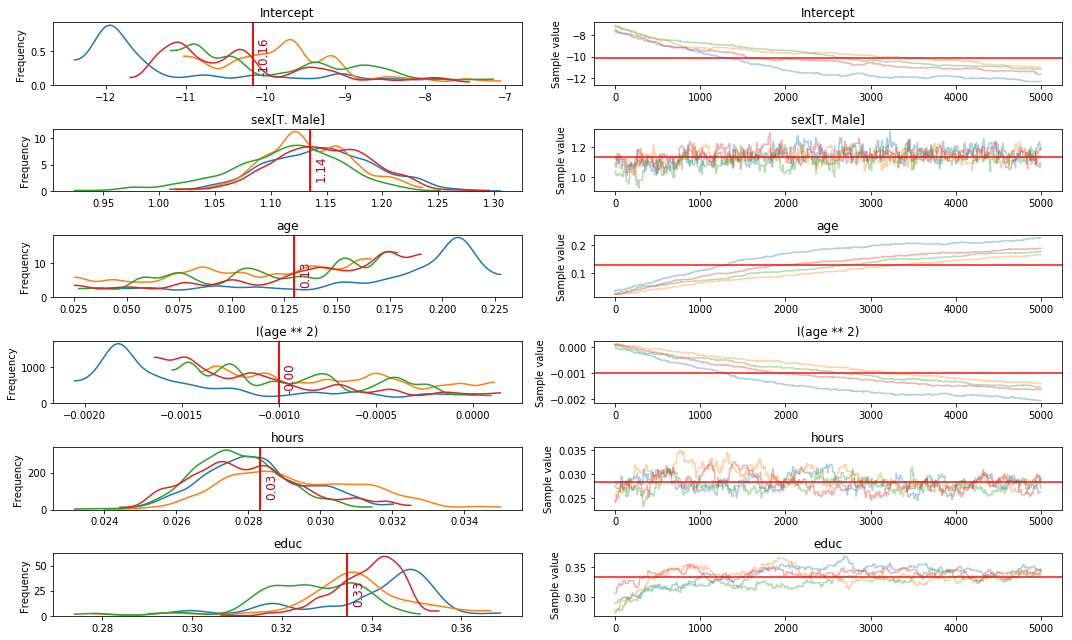

In [25]:
plot_traces(trace_mh, burnin=0)

In [26]:
pm.trace_to_dataframe(trace_mh).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 6 columns):
Intercept       20000 non-null float64
sex[T. Male]    20000 non-null float64
age             20000 non-null float64
I(age ** 2)     20000 non-null float64
hours           20000 non-null float64
educ            20000 non-null float64
dtypes: float64(6)
memory usage: 937.6 KB


### Continue Training

In [27]:
with logistic_model:
    trace_mh = pm.sample(draws=50000,
                         step=pm.Metropolis(),
                         trace=trace_mh)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [educ]
>Metropolis: [hours]
>Metropolis: [I(age ** 2)]
>Metropolis: [age]
>Metropolis: [sex[T. Male]]
>Metropolis: [Intercept]
Sampling 4 chains: 100%|██████████| 202000/202000 [3:05:04<00:00, 18.19draws/s]  
The estimated number of effective samples is smaller than 200 for some parameters.


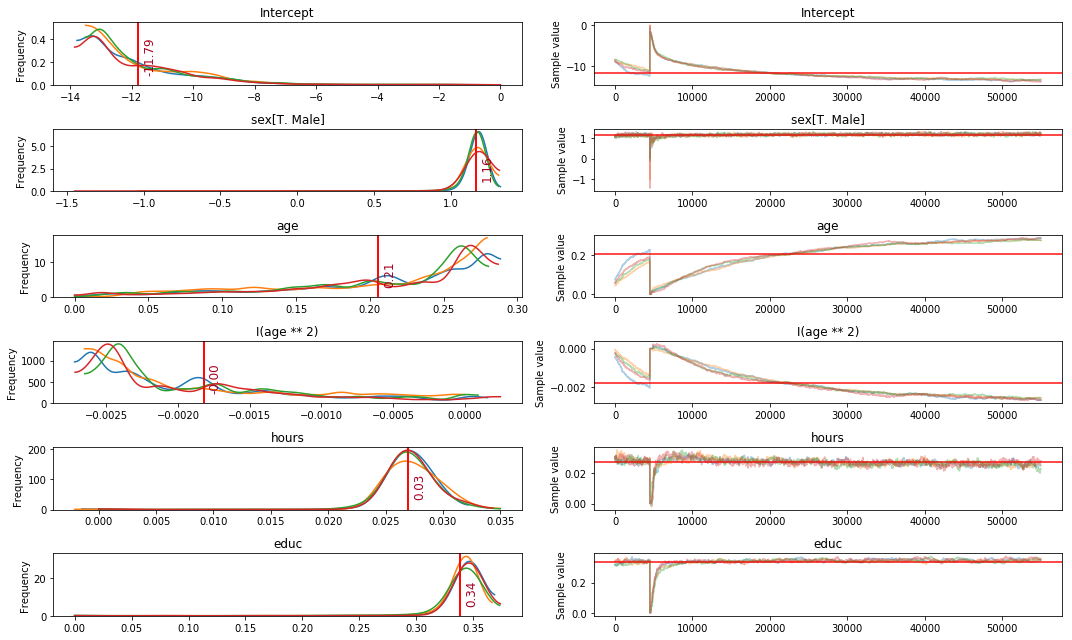

In [28]:
plot_traces(trace_mh, burnin=0)

In [33]:
with open(model_path / 'logistic_model_mh.pkl', 'wb') as buff:
    pickle.dump({'model': logistic_model, 'trace': trace_mh}, buff)

In [34]:
pm.summary(trace_mh)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
Intercept,-11.787778,1.777089,0.171152,-13.785676,-8.455286,14.010580,1.001814
sex[T. Male],1.162391,0.063885,0.004056,1.061655,1.262571,63.721624,1.003156
age,0.205541,0.071219,0.007049,0.058355,0.287755,11.705010,1.001347
I(age ** 2),-0.001822,0.000762,0.000075,-0.002704,-0.000238,11.544818,1.001402
hours,0.026945,0.002992,0.000193,0.023519,0.031850,171.499129,1.000883
educ,0.338701,0.030497,0.002267,0.315937,0.365790,95.228061,1.003296


### NUTS sampler
Using pm.sample without specifying a sampling method defaults to the No U-Turn Sampler, a form of Hamiltonian Monte Carlo that automatically tunes its parameters. It usually converges faster and gives less correlated samples compared to vanilla Metropolis-Hastings.

In [ ]:
cols = ['age', 'educ', 'hours']
data.loc[:, cols] = scale(data.loc[:, cols])

#### Draw small number of samples

In [ ]:
draws = 100
tune = 1000
with logistic_model:
    trace_NUTS = pm.sample(draws=draws, tune=1000,
                           init='adapt_diag',
                           chains=4, cores=2,
                           random_seed=42)

In [ ]:
trace_df = pm.trace_to_dataframe(trace_NUTS).assign(
    chain=lambda x: x.index // draws)
trace_df.info()

In [ ]:
plot_traces(trace_NUTS, burnin=0)

#### Continue Training

In [ ]:
draws = 25000
with logistic_model:
    trace_NUTS = pm.sample(draws=draws, tune=tune,
                           init='adapt_diag',
                           trace=trace_NUTS,
                           chains=4, cores=2,
                           random_seed=42)

#### Persist Results

In [ ]:
with open(model_path / 'logistic_model_nuts.pkl', 'wb') as buff:
    pickle.dump({'model': logistic_model,
                 'trace': trace_NUTS}, buff)

In [ ]:
with open(model_path / 'logistic_model_nuts.pkl', 'rb') as buff:
    data = pickle.load(buff)  

logistic_model, trace_NUTS = data['model'], data['trace']

#### Combine Traces

In [ ]:
df = pm.trace_to_dataframe(trace_NUTS).iloc[200:].reset_index(
    drop=True).assign(chain=lambda x: x.index // draws)
trace_df = pd.concat([trace_df.assign(samples=100),
                      df.assign(samples=25000)])
trace_df.info()

#### Visualize both traces

In [ ]:
trace_df_long = pd.melt(trace_df, id_vars=['samples', 'chain'])
trace_df_long.info()

In [ ]:
g = sns.FacetGrid(trace_df_long, col='variable', row='samples',
                  hue='chain', sharex='col', sharey=False)
g = g.map(sns.distplot, 'value', hist=False, rug=False)
g.savefig('figures/logistic_regression_comp', dpi=300)

In [ ]:
model = smf.logit(formula=full_model, data=data)
result = model.fit()
print(result.summary())

In [ ]:
pm.summary(trace_NUTS).assign(statsmodels=result.params)

In [ ]:
plot_traces(trace_NUTS, burnin=0)

### Computing Credible Intervals


Finally, we can find a credible interval (recall that credible intervals are Bayesian and confidence intervals are frequentist). This may be the best part about Bayesian statistics: we get to interpret credibility intervals the way we've always wanted to interpret them. We are 95% confident that the odds ratio lies within our interval!

In [ ]:
b = trace_NUTS['sex[T. Male]']
lb, ub = np.percentile(b, 2.5), np.percentile(b, 97.5)
lb, ub = np.exp(lb), np.exp(ub)
print(f'P({lb:.3f} < Odds Ratio < {ub:.3f}) = 0.95')

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))
sns.distplot(np.exp(b), axlabel='Odds Ratio', ax=ax)
ax.set_title(f'Credible Interval: P({lb:.3f} < Odds Ratio < {ub:.3f}) = 0.95')
ax.axvspan(lb, ub, alpha=0.5, color='gray');

## Variational Inference

### Run Automatic Differentation Variational Inference (ADVI)

In [ ]:
with logistic_model:
    callback = CheckParametersConvergence(diff='absolute')
    approx = pm.fit(n=100000, 
                    callbacks=[callback])

### Persist Result

In [ ]:
with open(model_path / 'logistic_model_advi.pkl', 'wb') as buff:
    pickle.dump({'model': logistic_model,
                 'approx': approx}, buff)

### Sample from approximated distribution

In [ ]:
trace_advi = approx.sample(10000)

In [ ]:
pm.summary(trace_advi)

In [ ]:
pm.summary(trace_advi).to_csv(model_path / 'trace_advi.csv')

## Model Diagnostics

### Energy Plot

In [ ]:
pm.energyplot(trace_NUTS)
# plt.savefig(fig_path / 'energyplot', dpi=300);

### Forest Plot

In [ ]:
pm.forestplot(trace_NUTS)
# plt.savefig(fig_path / 'forestplot', dpi=300);

### Posterior Predictive Checks

In [ ]:
ppc = pm.sample_ppc(trace_NUTS, samples=500, model=logistic_model)

In [ ]:
ppc['y'].shape

In [ ]:
y_score = np.mean(ppc['y'], axis=0)

In [ ]:
roc_auc_score(y_score=np.mean(ppc['y'], axis=0), 
              y_true=data.income)

## Prediction
Follows PyMC3 [docs](https://docs.pymc.io/notebooks/posterior_predictive.html)

### Train-test split

In [ ]:
data_numeric = data.assign(sex=lambda x: pd.factorize(x.sex)[0],
                           age2=lambda x: x.age**2)

In [ ]:
data_numeric = data[['income', 'hours']]

In [ ]:
X = data_numeric.drop('income', axis=1)
y = data_numeric.income
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42)
labels = X_train.columns

### Create shared theano variable

In [ ]:
X_shared = theano.shared(X_train.values)

### Define logistic model

In [ ]:
with pm.Model() as logistic_model_pred:
    pm.glm.GLM(x=X_shared, labels=labels,
               y=y_train, family=pm.glm.families.Binomial())

### Run NUTS sampler

In [ ]:
with logistic_model_pred:
    pred_trace = pm.sample(draws=10000, 
                           tune=1000,
                           chains=2,
                           cores=2,
                           init='adapt_diag')

### Replace shared variable with test set

In [ ]:
X_shared.set_value(X_test)

In [ ]:
ppc = pm.sample_ppc(pred_trace,
                    model=logistic_model_pred,
                    samples=100)

#### Check AUC Score

In [ ]:
y_score = np.mean(ppc['y'], axis=0)
roc_auc_score(y_score=np.mean(ppc['y'], axis=0), 
              y_true=y_test)

In [ ]:
def invlogit(x):
    return np.exp(x) / (1 + np.exp(x))

predictor = X_test['hours']

In [ ]:
fig, ax = plt.subplots(figsize=(14, 5))

β = stats.beta((ppc['y'] == 1).sum(axis=0), (ppc['y'] == 0).sum(axis=0))

# estimated probability
ax.scatter(x=predictor, y=β.mean())

# error bars on the estimate
plt.vlines(predictor, *β.interval(0.95))

# actual outcomes
ax.scatter(x=predictor, y=y_test, marker='x')

# True probabilities
x = np.linspace(predictor.min(), predictor.max())
ax.plot(x, invlogit(x), linestyle='-')

ax.set_xlabel('predictor')
ax.set_ylabel('outcome')
fig.tight_layout()
# fig.savefig(fig_path / 'predictions', dpi=300);

## MCMC Sampler Animation
The code is based on [MCMC visualization tutorial](https://twiecki.github.io/blog/2014/01/02/visualizing-mcmc/).

### Setup

In [ ]:
# Number of MCMC iteration to animate.
burnin = 1000
samples = 1000

var1 = 'sex[T. Male]'
var1_range = (trace_df[var1].min() * .95, trace_df[var1].max() * 1.05)

var2 = 'educ'
var2_range = (trace_df[var2].min() * .95, trace_df[var2].max() * 1.05)

In [ ]:
Writer = animation.writers['ffmpeg']
writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)

In [ ]:
with pm.Model() as logistic_model:
    pm.glm.GLM.from_formula(formula=full_model,
                            data=data,
                            family=pm.glm.families.Binomial())

### NUTS samples

In [ ]:
with logistic_model:
    nuts_trace = pm.sample(draws=samples, tune=burnin,
                      init='adapt_diag',
                      chains=1)
    nuts_trace = pm.trace_to_dataframe(trace)
# trace_df.to_csv('trace.csv', index=False)
# trace_df = pd.read_csv('trace.csv')
print(trace_df.info())

anim = animation.FuncAnimation(fig,
                               animate,
                               init_func=init,
                               frames=samples,
                               interval=5,
                               blit=True)

# save
# anim.save(fig_path / 'nuts.mp4', writer=writer)

# or display
HTML(anim.to_html5_video())

### Metropolis-Hastings samples

In [ ]:
with logistic_model:
    step = pm.Metropolis()
    mh_trace = pm.sample(draws=samples, tune=burnin,
                      step=step,
                      chains=1)
    trace_df = pm.trace_to_dataframe(mh_trace)

In [ ]:
fig = plt.figure(figsize=(8, 8))
ax1 = fig.add_subplot(221, xlim=var1_range, ylim=(0, samples))
ax2 = fig.add_subplot(224, xlim=(0, samples), ylim=var2_range)
ax3 = fig.add_subplot(223, xlim=var1_range, ylim=var2_range,
                      xlabel=var1, ylabel=var2)

fig.subplots_adjust(wspace=0.0, hspace=0.0)
line1, = ax1.plot([], [], lw=1)
line2, = ax2.plot([], [], lw=1)
line3, = ax3.plot([], [], 'o', lw=2, alpha=.1)
line4, = ax3.plot([], [], lw=1, alpha=.3)
line5, = ax3.plot([], [], 'k', lw=1)
line6, = ax3.plot([], [], 'k', lw=1)
ax1.set_xticklabels([])
ax2.set_yticklabels([])
lines = [line1, line2, line3, line4, line5, line6]

def init():
    for line in lines:
        line.set_data([], [])
    return lines

def animate(i):
    trace = trace_df.iloc[:i+1]
    idx = list(range(len(trace)))
    line1.set_data(trace[var1].iloc[::-1], idx)
    line2.set_data(idx, trace[var2].iloc[::-1])
    line3.set_data(trace[var1], trace[var2])
    line4.set_data(trace[var1], trace[var2])
    line5.set_data([trace[var1].iloc[-1], trace[var1].iloc[-1]], [trace[var2].iloc[-1], var2_range[1]])
    line6.set_data([trace[var1].iloc[-1], var1_range[1]], [trace[var2].iloc[-1], trace[var2].iloc[-1]])
    return lines

In [ ]:
anim = animation.FuncAnimation(fig,
                               animate,
                               init_func=init,
                               frames=samples,
                               interval=5,
                               blit=True)

In [ ]:
anim.save(fig_path / 'metropolis_hastings.mp4', writer=writer)

# HTML(anim.to_html5_video())